# Improving the Graph

## Steps

* Get the contigs and calculate the coverage
    * Align the contigs to reads using Minimap2
    * Sort the aligments using Samtools
    * Obtain the dept of each contig position using Samtools depth

* Get the coverage of links in the graph
    * For each link, obtain the connection sequence by connecting the latter 50% of first contig with first 50% of the next contig
    * Obtain the coverage as in the same way above

## Extracting Contigs, Links and Connection Contigs from the GFA file

In [8]:
![ ! -e 'links' ] && mkdir 'links'
![ ! -e 'contigs' ] && mkdir 'contigs'
![ ! -e 'mappings' ] && mkdir 'mappings'


import gfapy as gf
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import DNAAlphabet
from Bio import SeqIO

gfa = gf.Gfa.from_file('./graphs/assembly_graph.gfa')

segments = {}
contig_lengths = {}


def get_aligning_sequences(s1, o1, s2, o2):
    seq1 = Seq(s1)
    seq2 = Seq(s2)

    if (o1 == '-'):
        seq1 = seq1.reverse_complement()
    
    if (o2 == '-'):
        seq2 = seq2.reverse_complement()

    return seq1, seq2

for x in gfa.segments:
    segments[x.name] = x
    contig_lengths[x.name] = len(x.sequence)
    record1 = SeqRecord(Seq(x.sequence, DNAAlphabet),
                        id=x.name, description="Contig name="+x.name)
    SeqIO.write(record1, "./contigs/" + x.name, "fasta")
    
    

for x in gfa.dovetails:
    seq1, seq2 = get_aligning_sequences(x.from_segment.sequence, x.from_orient, x.to_segment.sequence, x.to_orient)

    idstr = x.from_segment.name + x.from_orient + x.to_segment.name + x.to_orient
#   TODO check if we need to get half or a weighted amount considering the read lengths
    record = SeqRecord(seq1[round(-1*len(seq1)/2)::] + seq2[0:int(len(seq2)/2)],
                        id=idstr, description="")

    SeqIO.write(record, "./links/"+idstr, "fasta")


# Computing Coverage of Links and Contigs

## Function to Obtain Coverage of Contigs

In [9]:
from pathlib import Path

def compute_contig_coverage(folder):
    paths = Path(folder).glob('**/*')
    readspath = "../Assembly/Sampled Reads/"

    coverage_dict = {}

    for p in [str(p) for p in paths]:
        fname = p.split("/").pop()
        print("INFO::Inspecting path = " + p)

        !minimap2 -a "$p" "$readspath"sd_0004.fastq.gz > out.txt
        !samtools sort out.txt > out.sorted.txt
        !samtools depth out.sorted.txt > out.txt

        tot = !cut -f3 out.txt | paste -sd+ | bc
        lines = !wc -l out.txt

        tot = float(tot[0])
        lines = float(lines[0].split()[0])

        coverage = tot/lines
        !rm out.txt
        !rm out.sorted.txt

        coverage_dict[fname] = coverage
    return coverage_dict

In [11]:
# Running Coverage Calculation for Contigs

contig_coverage = compute_contig_coverage("./contigs/")

print(contig_coverage)

INFO::Inspecting path = contigs/contig_3
[M::mm_idx_gen::0.042*1.02] collected minimizers
[M::mm_idx_gen::0.052*1.40] sorted minimizers
[M::main::0.052*1.40] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.056*1.37] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.059*1.35] distinct minimizers: 325791 (99.89% are singletons); average occurrences: 1.001; average spacing: 5.363
[M::worker_pipeline::10.176*2.39] mapped 19248 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a contigs/contig_3 ../Assembly/Sampled Reads/sd_0004.fastq.gz
[M::main] Real time: 10.202 sec; CPU: 24.393 sec; Peak RSS: 0.493 GB
INFO::Inspecting path = contigs/contig_2
[M::mm_idx_gen::0.048*1.02] collected minimizers
[M::mm_idx_gen::0.058*1.37] sorted minimizers
[M::main::0.058*1.37] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.063*1.34] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #

## Function to Obtain Coverage of Links

In [24]:
import re
import numpy as np
import matplotlib.pyplot as plt

def get_match_from_cigar(cigar):
    matches = re.findall(r'(\d+)M', cigar)
    misses = re.findall(r'(\d+)H', cigar)
    deletions = re.findall(r'(\d+)D', cigar)
    insertions = re.findall(r'(\d+)I', cigar)
    
    return sum(map(int, matches)), sum(map(int, misses)), sum(map(int, deletions)), sum(map(int, insertions))
    

def obtain_relevant_mappings(mapping_file, output_file, contig1_length, contig2_length):
    print ("INFO:: Filtering irrelavant maps")
    with open(output_file, 'w+') as outf:
        with open(mapping_file, 'r') as mapf:
            line_o = mapf.readline()
            line = line_o.split()
            # consume headers
            while line_o[0] == "@":
                outf.write(line_o)
                line_o = mapf.readline()
                line = line_o.split()
            while line_o:
                # mapping attributes
                pos = int(line[3])

                if pos == 0: 
                    line_o = mapf.readline()
                    line = line_o.split()
                    continue # no match found
                else:
                    # match found
                    matches, misses, deletions, insertions = get_match_from_cigar(line[5])
                    
                    # ensure mappings including both links are taken
                    match_starts_contig1 = (pos-1) < contig1_length / 2
                    match_ends_contig2 = sum([matches, misses, deletions, insertions]) + pos > contig1_length / 2

                    # if matches are from both links it is a valid mapping
                    if match_starts_contig1 and match_ends_contig2: # and matches / (matches + misses + deletions + insertions) > 0.9:
                        outf.write(line_o)
                
                line_o = mapf.readline()
                line = line_o.split()
    print ("INFO:: Done filtering irrelavant maps")
    
def get_coverage_from_file_name(fname):
    content = re.split('\+|\-',fname)
    valid_content = []
    
    for x in content:
        if len(x.strip()) > 0:
            valid_content.append(x.strip())
    
    return contig_coverage[valid_content[0]], contig_coverage[valid_content[1]]
    
def compute_link_coverage(folder, read_coverage=50):
    paths = Path(folder).glob('**/*')
    readspath = "../Assembly/Sampled Reads/"

    coverage_dict = {}

    for p in [str(p) for p in paths]:
        fname = p.split("/").pop()
        
        c1_len, c2_len = get_coverage_from_file_name(fname)
        
        print("INFO::Inspecting link = " + p)

        !minimap2 -a "$p" "$readspath"sd_0004.fastq.gz > unfiltered.out.txt
        
        obtain_relevant_mappings('unfiltered.out.txt', 'filtered.out.txt', c1_len, c2_len)
                
        !samtools sort filtered.out.txt > filtered.out.sorted.txt
        
        basewise_coverage = !samtools depth filtered.out.sorted.txt
        
        data = [int(x.split()[2]) for x in basewise_coverage]
        npd = np.array(data)

        n, bins, patches = plt.hist(x=npd, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Coverage')
        plt.ylabel('Occurances')
        plt.title('Coverage Distribution')
        maxfreq = n.max()
        # Set a clean upper y-axis limit.
        plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
        plt.show()
        plt.figure()
        mean = npd.mean() * 2 # because we consider half's coverage for the whole contigs (correction)
        std = npd.std()
        
        print("Mean", mean, "Std", std)

        !rm unfiltered.out.txt
        !rm filtered.out.txt
        !rm filtered.out.sorted.txt

        coverage_dict[fname] = mean
    return coverage_dict

INFO::Inspecting link = links/contig_1-contig_3-
[M::mm_idx_gen::0.030*1.02] collected minimizers
[M::mm_idx_gen::0.037*1.40] sorted minimizers
[M::main::0.037*1.40] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.041*1.37] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.043*1.35] distinct minimizers: 221062 (99.93% are singletons); average occurrences: 1.001; average spacing: 5.366
[M::worker_pipeline::9.457*2.35] mapped 19248 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a links/contig_1-contig_3- ../Assembly/Sampled Reads/sd_0004.fastq.gz
[M::main] Real time: 9.477 sec; CPU: 22.247 sec; Peak RSS: 0.495 GB
INFO:: Filtering irrelavant maps
INFO:: Done filtering irrelavant maps


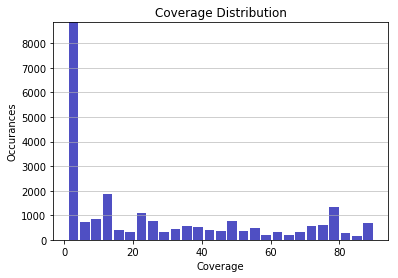

Mean 53.56647667299979 Std 28.849391730761702
INFO::Inspecting link = links/contig_1+contig_1+
[M::mm_idx_gen::0.020*1.06] collected minimizers
[M::mm_idx_gen::0.025*1.49] sorted minimizers
[M::main::0.025*1.49] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.027*1.46] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.028*1.44] distinct minimizers: 116659 (99.96% are singletons); average occurrences: 1.000; average spacing: 5.355
[M::worker_pipeline::8.347*2.28] mapped 19248 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a links/contig_1+contig_1+ ../Assembly/Sampled Reads/sd_0004.fastq.gz
[M::main] Real time: 8.349 sec; CPU: 19.054 sec; Peak RSS: 0.495 GB
INFO:: Filtering irrelavant maps
INFO:: Done filtering irrelavant maps


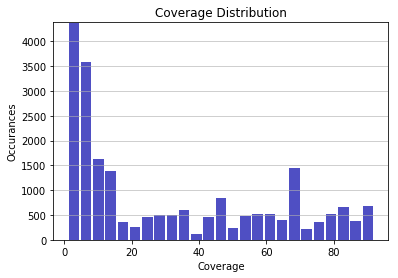

Mean 61.58660884972257 Std 29.683107970658213
INFO::Inspecting link = links/contig_3+contig_2+
[M::mm_idx_gen::0.045*1.01] collected minimizers
[M::mm_idx_gen::0.055*1.36] sorted minimizers
[M::main::0.055*1.36] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.059*1.33] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.062*1.31] distinct minimizers: 348807 (99.88% are singletons); average occurrences: 1.001; average spacing: 5.367
[M::worker_pipeline::10.801*2.43] mapped 19248 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a links/contig_3+contig_2+ ../Assembly/Sampled Reads/sd_0004.fastq.gz
[M::main] Real time: 10.806 sec; CPU: 26.243 sec; Peak RSS: 0.509 GB
INFO:: Filtering irrelavant maps
INFO:: Done filtering irrelavant maps


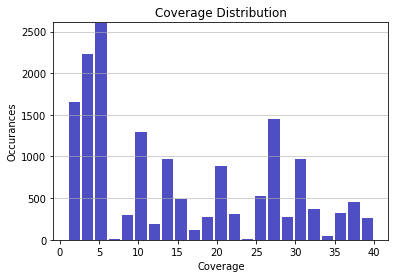

Mean 29.84450134265909 Std 11.599474881589288
INFO::Inspecting link = links/contig_1+contig_2+
[M::mm_idx_gen::0.036*1.01] collected minimizers
[M::mm_idx_gen::0.043*1.33] sorted minimizers
[M::main::0.043*1.33] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.046*1.31] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.048*1.30] distinct minimizers: 241249 (98.56% are singletons); average occurrences: 1.014; average spacing: 5.363
[M::worker_pipeline::10.158*2.40] mapped 19248 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a links/contig_1+contig_2+ ../Assembly/Sampled Reads/sd_0004.fastq.gz
[M::main] Real time: 10.161 sec; CPU: 24.361 sec; Peak RSS: 0.505 GB
INFO:: Filtering irrelavant maps
INFO:: Done filtering irrelavant maps


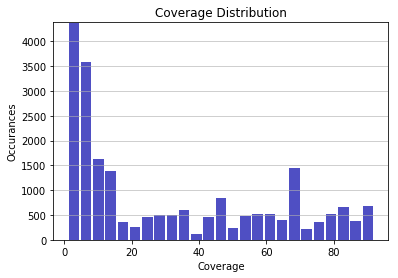

Mean 61.58660884972257 Std 29.683107970658213
{'contig_1-contig_3-': 53.56647667299979, 'contig_1+contig_1+': 61.58660884972257, 'contig_3+contig_2+': 29.84450134265909, 'contig_1+contig_2+': 61.58660884972257}


<Figure size 432x288 with 0 Axes>

In [25]:
# Running Coverage Calculation for Contigs and Links

link_coverage = compute_link_coverage("./links/")

print(link_coverage)

In [38]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

pp.pprint(contig_coverage)
print()
pp.pprint(link_coverage)


{   'contig_1': 99.67630348208557,
    'contig_2': 51.34579254187656,
    'contig_3': 49.193007481570504}

{   'contig_1+contig_1+': 61.58660884972257,
    'contig_1+contig_2+': 61.58660884972257,
    'contig_1-contig_3-': 53.56647667299979,
    'contig_3+contig_2+': 29.84450134265909}



In [42]:
# resolution of significant link cycles
# detect the cycle
#    get the coverage for link
#    if the link_coverage = read_covereage => contig x 2 and so on as it becomes multiples
#    contiguous occurances of the contig = link_coverage/read_coverage + 1
read_coverage = 50

def name_decomposer(link_name):
    decomposed = []
    temp = ""
    
    for c in link_name:
        temp += c
        if c == "+" or c == "-":
            contig_name = temp
            temp = ""
            decomposed.extend([contig_name, c])
    return decomposed

def round_to_coverage(x, base=read_coverage):
    return int(base * round(float(x)/base))

def resolve_links(links_array):
    resolved_links = []
    for link in links_array:
        if not True:
            resolved_links.append(link)
        link_coverage = link_coverage[link]
        ratio = round_to_coverage(link_coverage) / read_coverage
        
        double_repeats = int(ratio / 2) + 1 
        singlets = ratio % 2
        
        for repeat in double_repeats:
            resolve_links.append(link)
        
            

['contig_3+', '+', 'contig_2+', '+']


In [235]:
# Corresponds to Nodes of the Graph
class Contig:
    def __init__(self, name):
        # identified by the k-mers
        self._name = name
        self._next_contigs = []
        self._previous_contigs = []
        
    def add_next(self, contig):
        self._next_contigs.append(contig)
    
    def add_previous(self, contig):
        self._previous_contigs.append(contig)
        
    def has_parent(self):
        return len(self._previous_contigs) != 0
    
    def has_next(self):
        return len(self._next_contigs) != 0
        
class Graph:
    def __init__(self):
        self._links = []
        self._parent_index = {} # links whose parent is the key
        self._child_index = {} # links whose child is the key
    
    def add_link(self, parent, child, parent_orientation, child_orientation):
        # detect feasible link
        c_parent = child
        c_child = parent
        
        if parent_orientation == '+' : c_parent_orientation = '-'
        else: c_parent_orientation = '+'
        
        if child_orientation == '+' : c_child_orientation = '-'
        else: c_child_orientation = '+'
            
        # identify potential child and orientation
        _link_added = False
        
        for link in self._links:
            # try adding as parent
            if link._parent == child and link._parent_orientation == child_orientation:
                self._links.append(Link(parent, child, parent_orientation, child_orientation))
                _link_added = True
                break
            elif link._parent == c_child and link._parent_orientation == c_child_orientation:
                self._links.append(Link(c_parent, c_child, c_parent_orientation, c_child_orientation))
                _link_added = True
                break
            
            # try adding as child
            elif link._child == parent and link._child_orientation == parent_orientation:
                self._links.append(Link(parent, child, parent_orientation, child_orientation))
                _link_added = True
                break
            elif link._child == c_parent and link._child_orientation == c_parent_orientation:
                self._links.append(Link(c_parent, c_child, c_parent_orientation, c_child_orientation))
                _link_added = True
                break
                
        if not _link_added: 
            # this happens either at beginning or when neighbours have not found YET or when there is an isolated link
            # always choose the positive paths
            # TODO investigate if its possible to have a Link with +- both at the same time
            if parent_orientation == '+' or child_orientation == '+':
                self._links.append(Link(parent, child, parent_orientation, child_orientation))
            else:
                self._links.append(Link(c_parent, c_child, c_parent_orientation, c_child_orientation))
                    
    def index_graph(self):
        # Assuming the graph has been fully resolved, this could be a list of possible Links if theres branching
        # TODO Replace with a List instead of direct assignment
        for link in self._links:
            self._parent_index[link._parent] = link
            self._child_index[link._child] = link
    
    def deduce_proper_linkage(self):
        # TODO make this a class level variable if needed
        # TODO this might not be a list like this; if there is branching, this might yet be a graph
        _linkage = [self._links[0]]
        
        _linkage_extended = True
        
        while _linkage_extended:
            _linkage_extended = False
            
            # extending last
            _last = _linkage[-1]
            
            if _last._child in self._parent_index:
                _next_link = self._parent_index[_last._child]
                _linkage.append(_next_link)
                del self._parent_index[_last._child]
                _linkage_extended = True
                
            # extending the first
            _first = _linkage[0]
            if _first._parent in self._child_index:
                _next_link = self._child_index[_first._parent]
                _linkage.append(_next_link)
                del self._child_index[_first._parent]
                _linkage_extended = True
                
        print(_linkage)
                
            
        

    
    
    

In [236]:
linkage_graph = Graph()

'''
contig_1+contig_1+
contig_1+contig_2+
contig_1-contig_3-
contig_3+contig_2+
'''

linkage_graph.add_link('contig_1', 'contig_1', '+', '+')
linkage_graph.add_link('contig_1', 'contig_2', '+', '+')
linkage_graph.add_link('contig_1', 'contig_3', '-', '-')
linkage_graph.add_link('contig_3', 'contig_2', '+', '+')

linkage_graph.index_graph()

print(linkage_graph._child_index, '\n\n', linkage_graph._parent_index)

linkage_graph.deduce_proper_linkage()

{'contig_1': <__main__.Link object at 0x7fc7c58e3240>, 'contig_2': <__main__.Link object at 0x7fc7c58e3828>} 

 {'contig_1': <__main__.Link object at 0x7fc7c58e36a0>, 'contig_3': <__main__.Link object at 0x7fc7c58e3828>}
[<__main__.Link object at 0x7fc7c58e3eb8>, <__main__.Link object at 0x7fc7c58e36a0>, <__main__.Link object at 0x7fc7c58e3240>]
